## Setup and imports

In [1]:
# Clone the transformers repository and checkout a specific version
! git clone https://github.com/huggingface/transformers.git
! cd transformers && git checkout v4.57.0
! cd transformers && git tag --points-at HEAD

Cloning into 'transformers'...
Updating files:  27% (1467/5245)
Updating files:  28% (1469/5245)
Updating files:  29% (1522/5245)
Updating files:  30% (1574/5245)
Updating files:  31% (1626/5245)
Updating files:  32% (1679/5245)
Updating files:  33% (1731/5245)
Updating files:  34% (1784/5245)
Updating files:  35% (1836/5245)
Updating files:  36% (1889/5245)
Updating files:  37% (1941/5245)
Updating files:  38% (1994/5245)
Updating files:  39% (2046/5245)
Updating files:  40% (2098/5245)
Updating files:  41% (2151/5245)
Updating files:  42% (2203/5245)
Updating files:  43% (2256/5245)
Updating files:  44% (2308/5245)
Updating files:  44% (2353/5245)
Updating files:  45% (2361/5245)
Updating files:  46% (2413/5245)
Updating files:  47% (2466/5245)
Updating files:  48% (2518/5245)
Updating files:  49% (2571/5245)
Updating files:  50% (2623/5245)
Updating files:  51% (2675/5245)
Updating files:  52% (2728/5245)
Updating files:  53% (2780/5245)
Updating files:  54% (2833/5245)
Updating fil

v4.57.0


In [2]:
# Get git log of changes made after January 1, 2023
! cd transformers && git log --name-only --pretty=format:"%ad - %an: %s" --after="2023-01-01" > ../git_log_output.txt

In [38]:
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict, Counter
from pygount import SourceAnalysis

## Task 1

### Detect defect commits

In [31]:
def get_commit_message(line):
    parts = line.split(": ")
    if len(parts) < 2:
        return ""
    return ": ".join(parts[1:])  # Join back in case there are multiple colons

# Filter git log output for defect-related commits based on the following words
defect_keywords = ["fix", "bug", "error", "issue", "patch"]

defect_commits = []
with open('git_log_output.txt', encoding='utf-8') as infile:
        for line in infile:
            # Check it is a commit line
            if not line[:3] in ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]:
                continue

            message = get_commit_message(line)
            if any(keyword in message.lower() for keyword in defect_keywords):
                defect_commits.append(line)
print(f"Found {len(defect_commits)} defect commits")

Found 3179 defect commits


### Total number of defects per month

In [29]:
month = {
    "Jan": "01", "Feb": "02", "Mar": "03", "Apr": "04", "May": "05", "Jun": "06",
    "Jul": "07", "Aug": "08", "Sep": "09", "Oct": "10", "Nov": "11", "Dec": "12"
}

defect_per_month = {"10/2025": 0}  # initialize with last month in the log: October 2025
# For each defect commit, extract the month and year, and count occurrences
for c in defect_commits:
    parts = c.split()
    # e.g., Mon Nov 10 22:36:21 2025 +0800 - automan: fix qwen2vl/qwen3vl video processor temporal padding when num_frames%temporal_patch_size!=1 (#42083)
    # Month is always on the 2nd position, year is always on the 5th position 
    mon = parts[1]
    year = parts[4]
    if mon in month:
        key = f"{month[mon]}/{year}"
        defect_per_month[key] = defect_per_month.get(key, 0) + 1

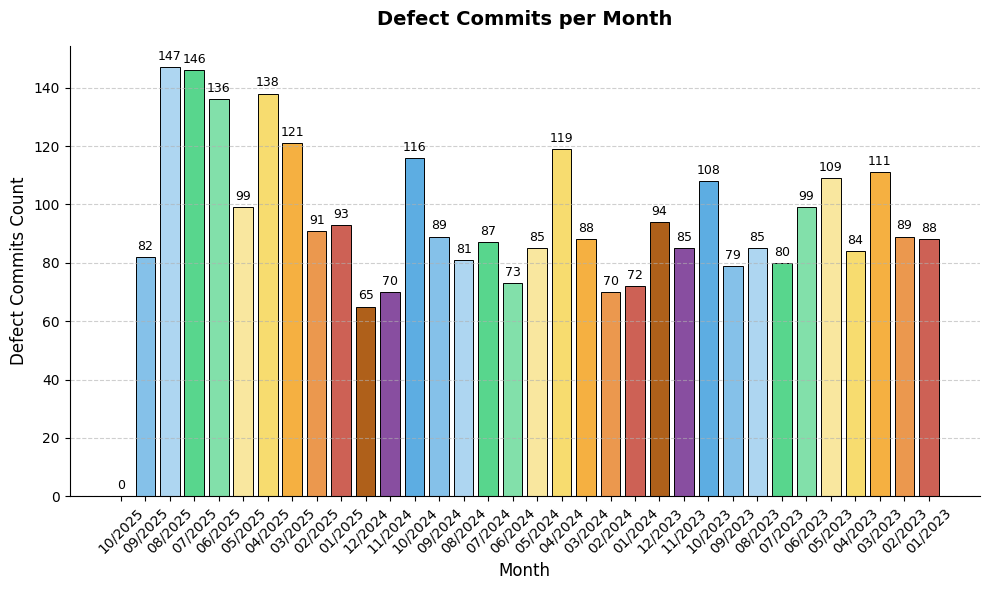

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))

month = list(defect_per_month.keys())
counts = list(defect_per_month.values())

bar_colors = [
    "#5DADE2", "#85C1E9", "#AED6F1", "#58D68D",
    "#82E0AA", "#F9E79F", "#F7DC6F", "#F5B041",
    "#EB984E", "#CD6155", "#AF601A", "#884EA0"
]


# Create the bar chart
bars = ax.bar(month, counts, color=bar_colors, edgecolor="black", linewidth=0.7)

# Add counts above bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # small offset above bar
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9, color='black')
    
# Titles and labels
ax.set_title("Defect Commits per Month", fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Defect Commits Count", fontsize=12)

# X-axis formatting
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Grid and layout improvements
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

### Number of defects per month for the two files with the highest number of defects

Top 1 defect file: src/transformers/modeling_utils.py
Top 2 defect file: src/transformers/trainer.py


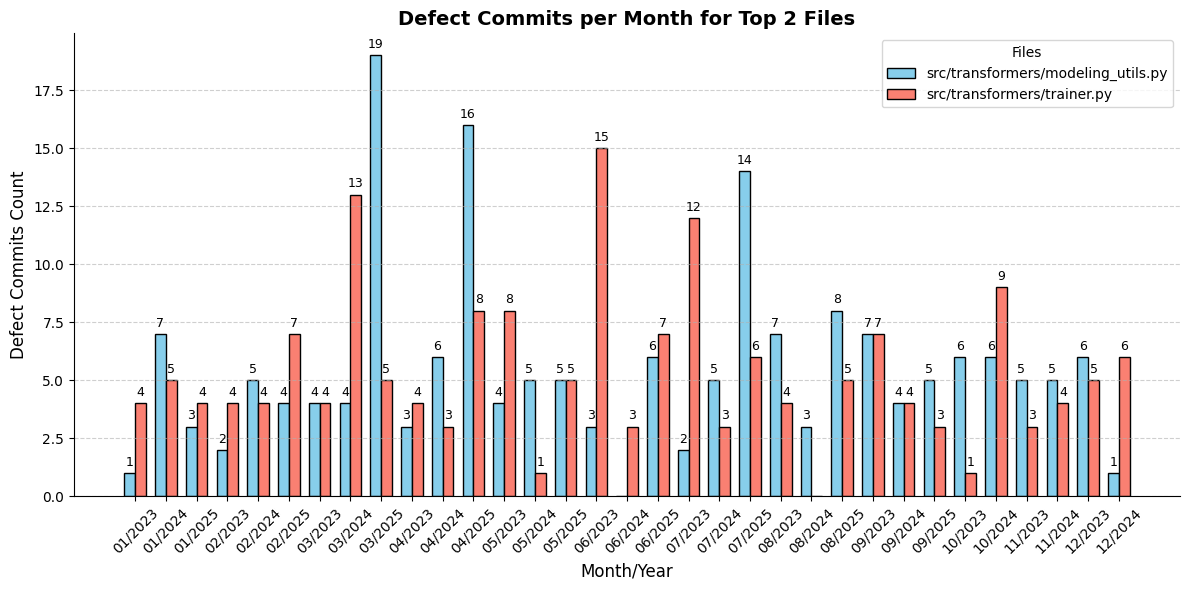

In [26]:
def parse_git_log(filepath):
    # Map short month names to numbers (used for date formatting)
    month_map = {
        "Jan": "01", "Feb": "02", "Mar": "03", "Apr": "04", "May": "05", "Jun": "06",
        "Jul": "07", "Aug": "08", "Sep": "09", "Oct": "10", "Nov": "11", "Dec": "12"
    }

    # Read and group commits from the log file
    commits = _parse_commits(filepath)

    # Keep only commits that look like defect fixes >> {"fix", "bug", "error", "issue"}
    defect_commits = _filter_defect_commits(commits)

    # Count how many defects are linked to each file
    defect_counts = _count_defects_by_file(defect_commits)

    # Find the top 2 files with the most defects
    top_files = _get_top_files(defect_counts, top_n=2)

    # Print which files had the most defects
    _print_top_files(top_files)

    # Count how many defects happened per month for these top files
    defect_per_month = _get_defects_per_month(defect_commits, top_files, month_map)
    
    # Find which month had the highest defect count
    max_month_numbers = get_month_with_max_counts(defect_per_month)

    # Get the full month names (e.g., “Mar”) that match those max counts
    max_count_per_month = [k for k, v in month_map.items() if v in max_month_numbers]

    # Collect commit logs for those months and top files
    logs = get_commit_logs_by_file(defect_commits, top_files, max_count_per_month)

    # Return monthly defect data and logs for further review
    return defect_per_month, logs


def _parse_commits(filepath):
    # Read commits from the git log file and group lines under each commit header
    commits = {}
    current_commit = None

    with open(filepath, encoding='utf-8') as infile:
        for line in infile:
            line = line.strip()
            if not line:
                continue
            # Lines starting with a weekday as a new commit 
            if line[:3] in ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]:
                current_commit = line
                commits[current_commit] = []
            # All other lines belong to the current commit
            elif current_commit:
                commits[current_commit].append(line)

    return commits


def _filter_defect_commits(commits):
    return {
        commit: files
        for commit, files in commits.items()
        if any(word in get_commit_message(commit).lower() for word in defect_keywords)
    }


def _count_defects_by_file(defect_commits):
    # Count how often each file appears in defect-related commits
    file_counter = Counter()
    for files in defect_commits.values():
        file_counter.update(files)
    return dict(file_counter)


def _get_top_files(defect_counts, top_n=2):
    # Sort files by number of defects and get the top ones
    sorted_files = sorted(defect_counts.items(), key=lambda x: x[1], reverse=True)
    return [f for f, _ in sorted_files[:top_n]]


def _print_top_files(top_files):
    # Print a short summary of top defect-prone files
    for idx, file in enumerate(top_files, start=1):
        print(f"Top {idx} defect file: {file}")


def _get_defects_per_month(commits, top_files, month_map):
    # Count defects for each top file, grouped by month and year
    defect_per_month = {file: defaultdict(int) for file in top_files}

    for commit, files in commits.items():
        parts = commit.split()
        if len(parts) >= 5:
            mon, year = parts[1], parts[4]
            if mon in month_map:
                key = f"{month_map[mon]}/{year}"
                # Add counts only for the top defect-prone files
                for f in top_files:
                    if f in files:
                        defect_per_month[f][key] += 1

    # Convert defaultdicts to normal dicts before returning
    return {f: dict(counts) for f, counts in defect_per_month.items()}
    

def get_month_with_max_counts(defect_per_month):
    # Find which month (by number) had the most defects overall
    month_count = {}
    for counts in defect_per_month.values():
        for key, value in counts.items():
            month = key.split('/')[0] 
            if month in month_count:
                month_count[month] += value
            else:
                month_count[month] = value 
    # Return the month(s) that had the highest defect count
    if month_count:
        max_count = max(month_count.values())
        max_months = [m for m, v in month_count.items() if v == max_count]
        return max_months


def get_commit_logs_by_file(commits, top_files, max_count_per_month):
    # Gather commit messages for top files during the month(s) with most defects
    logs = []
    for commit, files in commits.items(): 
        if any(f in top_files for f in files):
            parts = commit.split()
            mon, year = parts[1], parts[4]
            if mon in max_count_per_month and year == "2025":
                logs.append(commit)

    # Return all relevant commit lines
    return logs


# Get parsed data (dict: {filename: {month: count}})
defect_data, logs = parse_git_log("git_log_output.txt")

# Extract the top two files and their monthly data
top_files = list(defect_data.keys())
file1, file2 = top_files[0], top_files[1]

counts1 = defect_data[file1]
counts2 = defect_data[file2]

# Get the sorted list of months (x-axis)
months = sorted(set(counts1.keys()) | set(counts2.keys()))

# Extract counts aligned with months (fill 0 if missing)
y1 = [counts1.get(m, 0) for m in months]
y2 = [counts2.get(m, 0) for m in months]

# Plot setup
x = np.arange(len(months))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, y1, width, label=file1, color='skyblue', edgecolor='black')
bars2 = ax.bar(x + width/2, y2, width, label=file2, color='salmon', edgecolor='black')

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax.annotate(f'{height}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize=9, color='black')


# Labels and formatting
ax.set_ylabel('Defect Commits Count', fontsize=12)
ax.set_xlabel('Month/Year', fontsize=12)
ax.set_title('Defect Commits per Month for Top 2 Files', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(months, rotation=45)
ax.legend(title='Files')
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()
 

## Task 2

### Calculate LoC and NCC for all .py files in the repository

In [126]:
file_stats = {}

# Calculate LoC
for root, _, files in os.walk('transformers'):
    for file_name in files:
        if file_name.endswith('.py'):
            file_path = os.path.join(root, file_name)
            analysis = SourceAnalysis.from_file(file_path, 'py', fallback_encoding='utf-8')
            file_stats[file_path.replace('\\', '/').replace('transformers/', '', 1)] = {'loc': analysis.code_count, 'ncc': 0}

# Calculate NCC
files_not_found = set()
with open('git_log_output.txt', encoding='utf-8') as infile:
    for raw_line in infile:
        line = raw_line.strip()
        # Check it is a commit line
        if line[:3] in ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]:
            continue

        # Check for file line
        elif len(line) > 0 and line.endswith('.py'):
            if line in file_stats:
                file_stats[line]["ncc"] += 1
            else:
                # There may be files that were deleted or moved; track them
                files_not_found.add(line)
print(f"{len(files_not_found)} files from git log not found in LoC analysis.")

1096 files from git log not found in LoC analysis.


The following code is not verified, its AI generated

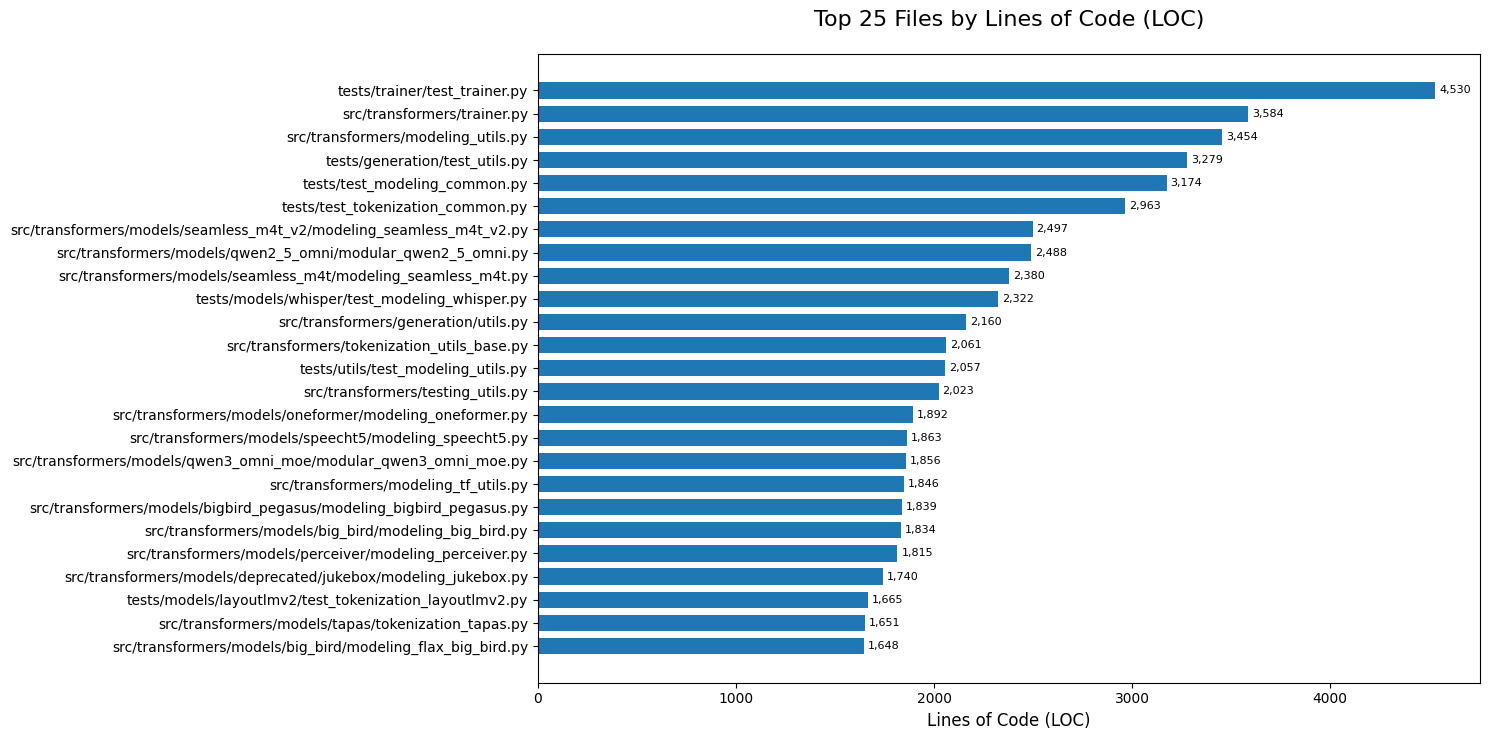

In [151]:
def plot_top_loc(stats_dict, top_n=100):
    """
    Sorts file statistics by 'loc' in descending order and plots the top N 
    entries as a horizontal bar chart.

    Args:
        stats_dict (dict): The input dictionary of file statistics.
        top_n (int): The number of entries to plot.
    """
    # 1. Convert the dictionary items into a list of (filename, loc_value) tuples
    # This is done by extracting the 'loc' value from the inner dictionary.
    data_list = [(filename, details["loc"]) 
                 for filename, details in stats_dict.items()]
    
    # 2. Sort the list by 'loc' (the second element, index 1) in reverse order.
    # The `key=lambda x: x[1]` specifies that sorting should use the LOC value.
    sorted_data = sorted(data_list, key=lambda item: item[1], reverse=True)
    
    # 3. Select the top N entries
    top_data = sorted_data[:top_n]
    
    # Separate the data into filenames (labels) and LOC values (bars)
    filenames = [item[0] for item in top_data]
    loc_values = [item[1] for item in top_data]

    # Handle the case where the input dictionary has less than top_n entries
    actual_n = len(top_data)
    if actual_n == 0:
        print("Error: The input dictionary is empty.")
        return

    # --- Plotting ---
    
    # Create the figure and axes
    # We use a larger figure size for better readability, especially for 100 bars.
    fig, ax = plt.subplots(figsize=(15, actual_n * 0.3)) # Height is dynamic based on number of bars

    # Create the horizontal bar chart
    bars = ax.barh(filenames, loc_values, color='#1f77b4', height=0.7) # 'barh' for horizontal bars

    # Add title and labels
    ax.set_title(f"Top {actual_n} Files by Lines of Code (LOC)", fontsize=16, pad=20)
    ax.set_xlabel("Lines of Code (LOC)", fontsize=12)
    
    # Adjust y-axis: filenames should be at the bottom for the highest LOC
    ax.invert_yaxis()  # Put highest LOC files (which are first in the list) at the top
    
    # Improve layout for better readability of long file names
    plt.tight_layout()
    
    # Optional: Add LOC values on the bars for clarity
    for bar in bars:
        ax.text(bar.get_width() + 20,  # x position (slightly to the right of the bar)
                bar.get_y() + bar.get_height()/2, # y position (center of the bar)
                f'{bar.get_width():,}',           # The text (LOC value with comma)
                va='center',                      # Vertical alignment
                fontsize=8,
                color='black')
    
    # Display the plot
    plt.show()

plot_top_loc(file_stats, top_n=25)

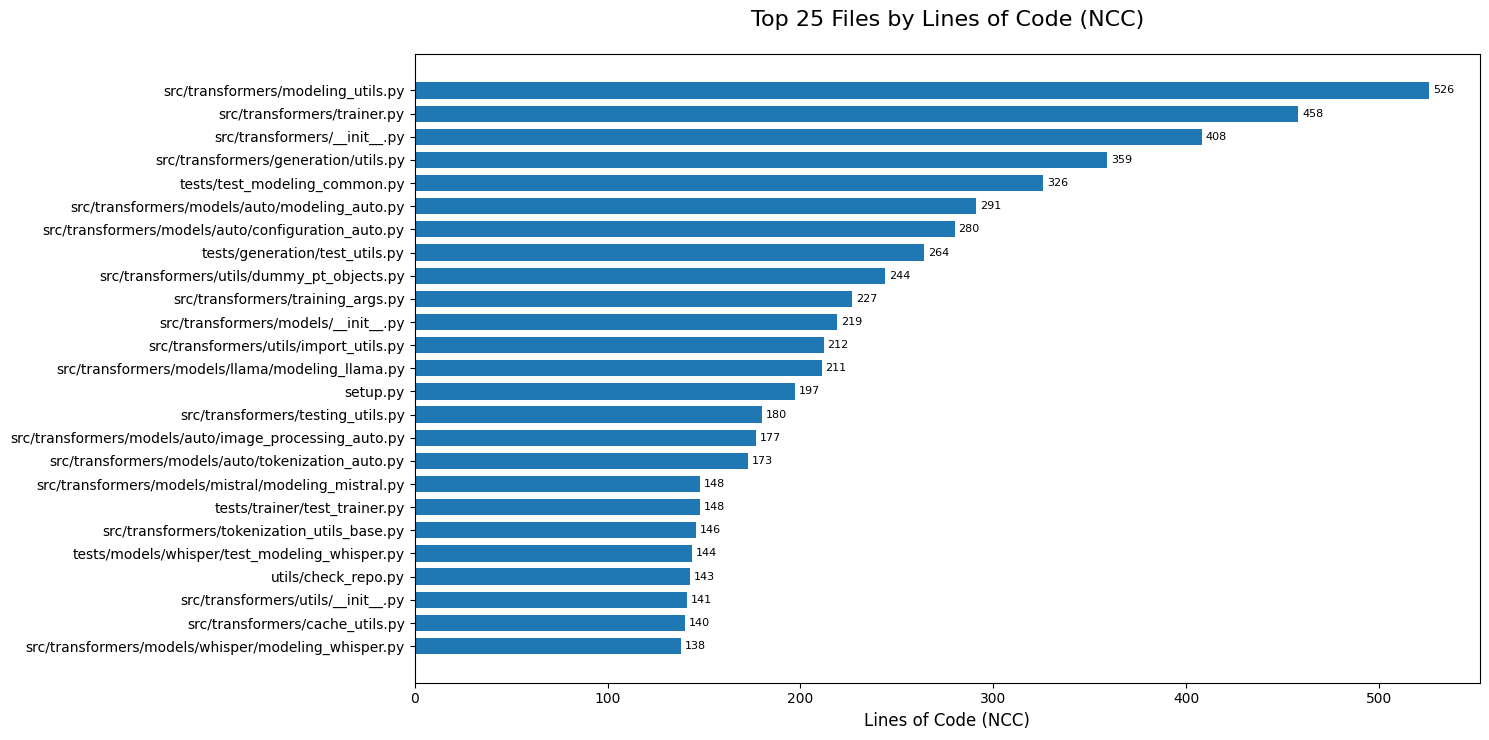

In [152]:
def plot_top_ncc(stats_dict, top_n=100):
    """
    Sorts file statistics by 'ncc' in descending order and plots the top N 
    entries as a horizontal bar chart.

    Args:
        stats_dict (dict): The input dictionary of file statistics.
        top_n (int): The number of entries to plot.
    """
    # 1. Convert the dictionary items into a list of (filename, ncc_value) tuples
    # This is done by extracting the 'ncc' value from the inner dictionary.
    data_list = [(filename, details["ncc"]) 
                 for filename, details in stats_dict.items()]
    
    # 2. Sort the list by 'ncc' (the second element, index 1) in reverse order.
    # The `key=lambda x: x[1]` specifies that sorting should use the NCC value.
    sorted_data = sorted(data_list, key=lambda item: item[1], reverse=True)
    
    # 3. Select the top N entries
    top_data = sorted_data[:top_n]
    
    # Separate the data into filenames (labels) and NCC values (bars)
    filenames = [item[0] for item in top_data]
    ncc_values = [item[1] for item in top_data]

    # Handle the case where the input dictionary has less than top_n entries
    actual_n = len(top_data)
    if actual_n == 0:
        print("Error: The input dictionary is empty.")
        return

    # --- Plotting ---
    
    # Create the figure and axes
    # We use a larger figure size for better readability, especially for 100 bars.
    fig, ax = plt.subplots(figsize=(15, actual_n * 0.3)) # Height is dynamic based on number of bars

    # Create the horizontal bar chart
    bars = ax.barh(filenames, ncc_values, color='#1f77b4', height=0.7) # 'barh' for horizontal bars

    # Add title and labels
    ax.set_title(f"Top {actual_n} Files by Lines of Code (NCC)", fontsize=16, pad=20)
    ax.set_xlabel("Lines of Code (NCC)", fontsize=12)
    
    # Adjust y-axis: filenames should be at the bottom for the highest NCC
    ax.invert_yaxis()  # Put highest NCC files (which are first in the list) at the top
    
    # Improve layout for better readability of long file names
    plt.tight_layout()
    
    # Optional: Add NCC values on the bars for clarity
    for bar in bars:
        ax.text(bar.get_width() + 2,  # x position (slightly to the right of the bar)
                bar.get_y() + bar.get_height()/2, # y position (center of the bar)
                f'{bar.get_width():,}',           # The text (NCC value with comma)
                va='center',                      # Vertical alignment
                fontsize=8,
                color='black')
    
    # Display the plot
    plt.show()

plot_top_ncc(file_stats, top_n=25)

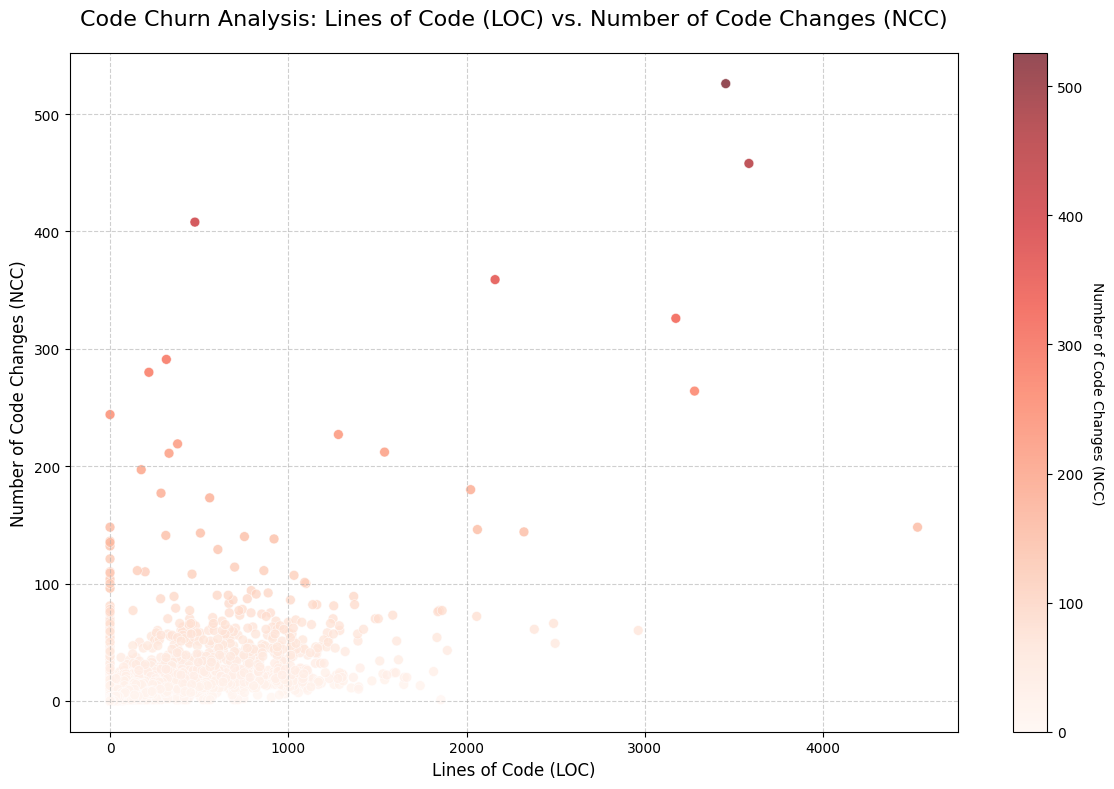

In [158]:
def plot_loc_vs_ncc_scatterplot(stats_dict):
    """
    Creates a scatterplot showing Lines of Code (LOC) on the x-axis
    versus Number of Code Changes (NCC) on the y-axis for all files.

    Args:
        stats_dict (dict): The input dictionary of file statistics.
    """
    if not stats_dict:
        print("Error: The input dictionary is empty.")
        return

    # 1. Extract data points
    filenames = []
    loc_values = [] # X-axis
    ncc_values = [] # Y-axis
    
    for filename, details in stats_dict.items():
        filenames.append(filename)
        # Ensure data is present before appending
        loc_values.append(details.get("loc", 0))
        ncc_values.append(details.get("ncc", 0))

    # --- Plotting ---
    
    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(12, 8)) 

    # 2. Create the scatterplot
    # Coloring the points by NCC helps visualize the magnitude of changes.
    scatter = ax.scatter(loc_values, ncc_values, 
                         c=ncc_values,          # Color based on NCC value
                         cmap='Reds',           # Using 'Reds' to signify "hotness"
                         s=50,                  # Size of markers
                         alpha=0.7,             # Transparency
                         edgecolors='w', linewidths=0.5)

    # 3. Add title and labels
    ax.set_title("Code Churn Analysis: Lines of Code (LOC) vs. Number of Code Changes (NCC)", fontsize=16, pad=20)
    ax.set_xlabel("Lines of Code (LOC)", fontsize=12)
    ax.set_ylabel("Number of Code Changes (NCC)", fontsize=12) # UPDATED LABEL

    # 4. Set the limits for the axes as requested
    # ax.set_xlim(0, 2000)
    # ax.set_ylim(0, 200)

    
    # Add a color bar to explain the colors
    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('Number of Code Changes (NCC)', rotation=270, labelpad=15) # UPDATED LABEL
    
    # Add grid for better reading
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # Improve layout
    plt.tight_layout()
    
    # Display the plot
    plt.show()

plot_loc_vs_ncc_scatterplot(file_stats)

Plotting 100 files (Top 100 by Complexity Score: NCC*10 + LOC)


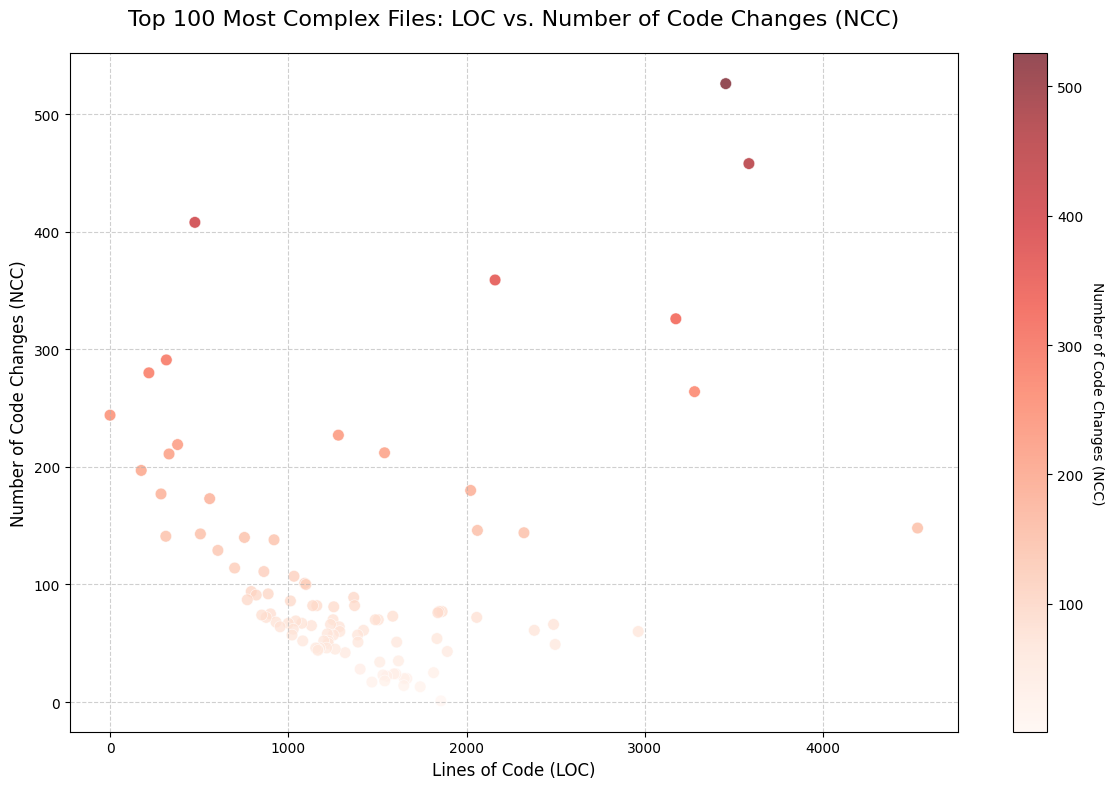

In [157]:
def plot_loc_vs_ncc_scatterplot(stats_dict):
    """
    Calculates complexity, filters to the top 100 most complex files,
    and creates a scatterplot of LOC vs. NCC for those files.

    Complexity Score Formula: ncc * 10 + loc
    
    Args:
        stats_dict (dict): The input dictionary of file statistics.
    """
    if not stats_dict:
        print("Error: The input dictionary is empty.")
        return

    # 1. Calculate Complexity Score and create a sortable list
    scored_data = []
    for filename, details in stats_dict.items():
        loc = details.get("loc", 0)
        ncc = details.get("ncc", 0)
        
        # New Complexity Formula: ncc * 10 + loc
        complexity_score = ncc * 10 + loc
        
        scored_data.append({
            "filename": filename,
            "loc": loc,
            "ncc": ncc,
            "score": complexity_score
        })

    # 2. Sort by complexity score in descending order
    # This places the most complex files at the beginning of the list
    scored_data.sort(key=lambda x: x["score"], reverse=True)

    # 3. Select the top 100 most complex entries (or all, if less than 100)
    top_100_files = scored_data[:100]
    
    # 4. Extract data points from the filtered list
    filenames = []
    loc_values = [] # X-axis
    ncc_values = [] # Y-axis

    for file_data in top_100_files:
        filenames.append(file_data["filename"])
        loc_values.append(file_data["loc"])
        ncc_values.append(file_data["ncc"])

    print(f"Plotting {len(top_100_files)} files (Top 100 by Complexity Score: NCC*10 + LOC)")

    # --- Plotting ---
    
    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(12, 8)) 

    # 5. Create the scatterplot
    # Coloring the points by NCC helps visualize the magnitude of changes within the top 100
    scatter = ax.scatter(loc_values, ncc_values, 
                         c=ncc_values,          # Color based on NCC value
                         cmap='Reds',           # Using 'Reds' to signify "hotness"
                         s=70,                  # Slightly larger markers to highlight the top 100
                         alpha=0.7,             # Transparency
                         edgecolors='w', linewidths=0.5)

    # 6. Add title and labels
    ax.set_title("Top 100 Most Complex Files: LOC vs. Number of Code Changes (NCC)", fontsize=16, pad=20)
    ax.set_xlabel("Lines of Code (LOC)", fontsize=12)
    ax.set_ylabel("Number of Code Changes (NCC)", fontsize=12) 

    # Add a color bar to explain the colors
    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('Number of Code Changes (NCC)', rotation=270, labelpad=15) 
    
    # Add grid for better reading
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # Improve layout
    plt.tight_layout()
    
    # Display the plot
    plt.show()

plot_loc_vs_ncc_scatterplot(file_stats)

Plotting 25 files (Top 25 by Complexity Score: NCC*10 + LOC)


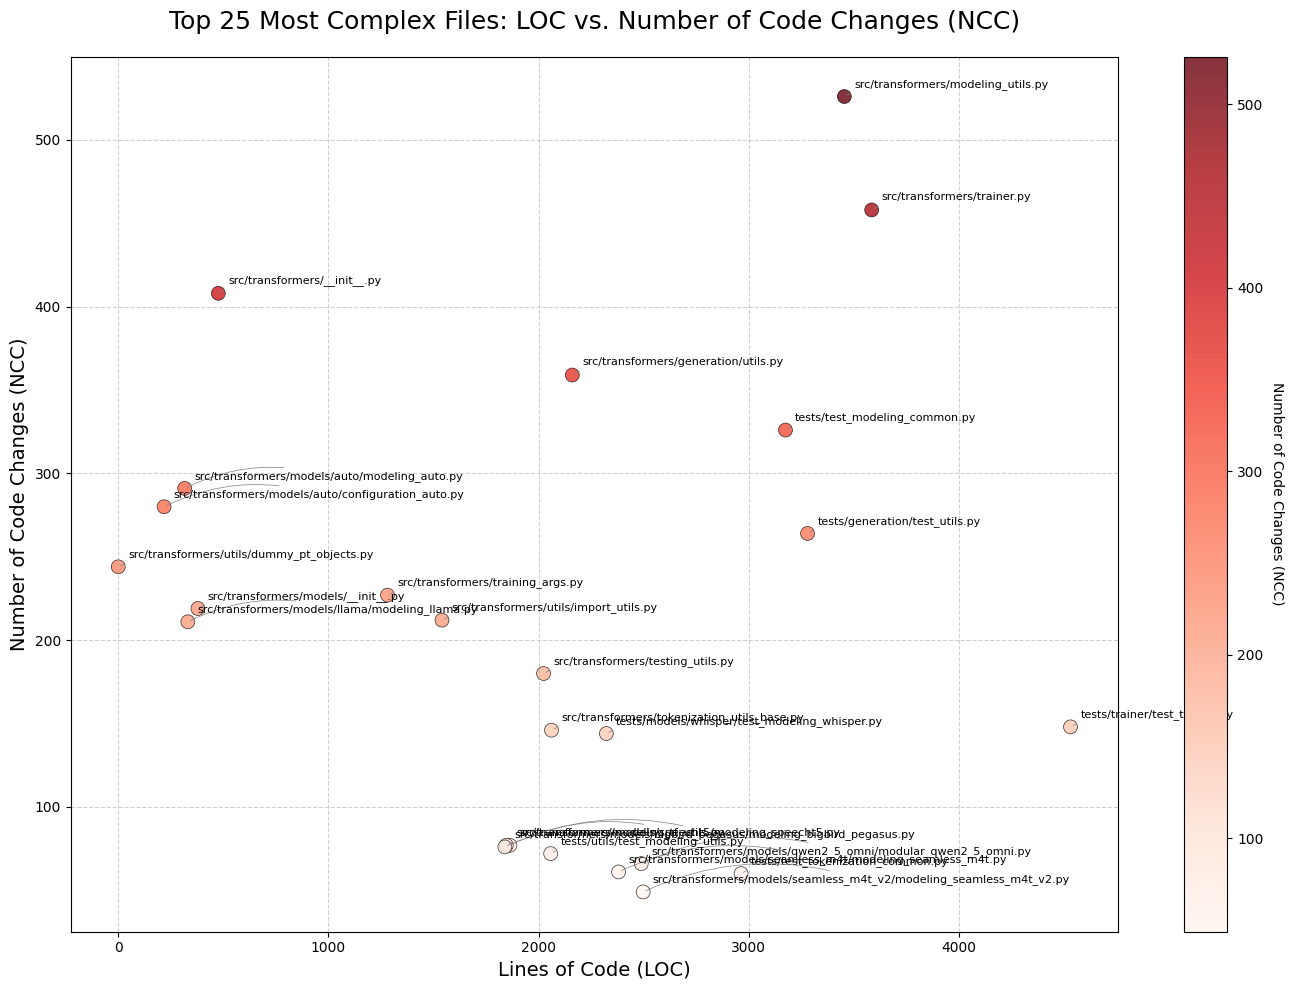

In [164]:
def plot_loc_vs_ncc_scatterplot(stats_dict):
    """
    Calculates complexity, filters to the top 25 most complex files,
    and creates a scatterplot of LOC vs. NCC for those files, including labels.

    Complexity Score Formula: ncc * 10 + loc
    
    Args:
        stats_dict (dict): The input dictionary of file statistics.
    """
    if not stats_dict:
        print("Error: The input dictionary is empty.")
        return

    # 1. Calculate Complexity Score and create a sortable list
    scored_data = []
    for filename, details in stats_dict.items():
        loc = details.get("loc", 0)
        ncc = details.get("ncc", 0)
        
        # New Complexity Formula: ncc * 10 + loc
        complexity_score = ncc * 10 + loc
        
        scored_data.append({
            "filename": filename,
            "loc": loc,
            "ncc": ncc,
            "score": complexity_score
        })

    # 2. Sort by complexity score in descending order
    # This places the most complex files at the beginning of the list
    scored_data.sort(key=lambda x: x["score"], reverse=True)

    # 3. Select the top 25 most complex entries
    top_files = scored_data[:25]
    
    # 4. Extract data points from the filtered list
    loc_values = [file["loc"] for file in top_files] # X-axis
    ncc_values = [file["ncc"] for file in top_files] # Y-axis
    
    print(f"Plotting {len(top_files)} files (Top 25 by Complexity Score: NCC*10 + LOC)")

    # --- Plotting ---
    
    # Create the figure and axes (Increased size for better label visibility)
    fig, ax = plt.subplots(figsize=(14, 10)) 

    # 5. Create the scatterplot
    scatter = ax.scatter(loc_values, ncc_values, 
                         c=ncc_values,          
                         cmap='Reds',           
                         s=100,                 # Increased marker size for visibility
                         alpha=0.8,             
                         edgecolors='k', linewidths=0.5)

    # 6. Add labels (Filenames) to the data points
    for file_data in top_files:
        # Annotate each point with its filename
        ax.annotate(
            file_data["filename"],
            (file_data["loc"], file_data["ncc"]),
            xytext=(7, 7),                     # Offset the text slightly from the point
            textcoords='offset points',
            fontsize=8,
            # ha='left',                         # Horizontal alignment
            # # Add a small arrow to connect the text to the point
            arrowprops=dict(arrowstyle="-", connectionstyle="arc3,rad=0.2", color='gray', lw=0.5)
        )


    # 7. Add title and axis labels
    ax.set_title("Top 25 Most Complex Files: LOC vs. Number of Code Changes (NCC)", fontsize=18, pad=20) 
    ax.set_xlabel("Lines of Code (LOC)", fontsize=14)
    ax.set_ylabel("Number of Code Changes (NCC)", fontsize=14) 

    # Add a color bar to explain the colors
    cbar = fig.colorbar(scatter, ax=ax)
    cbar.set_label('Number of Code Changes (NCC)', rotation=270, labelpad=15) 
    
    # Add grid for better reading
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # Improve layout
    plt.tight_layout()
    
    # Display the plot
    plt.show()

plot_loc_vs_ncc_scatterplot(file_stats)